
Processing (MeanShift): fat2.jpg
Estimated bandwidth: 20.5376
Fat Area (MeanShift): 60.61%


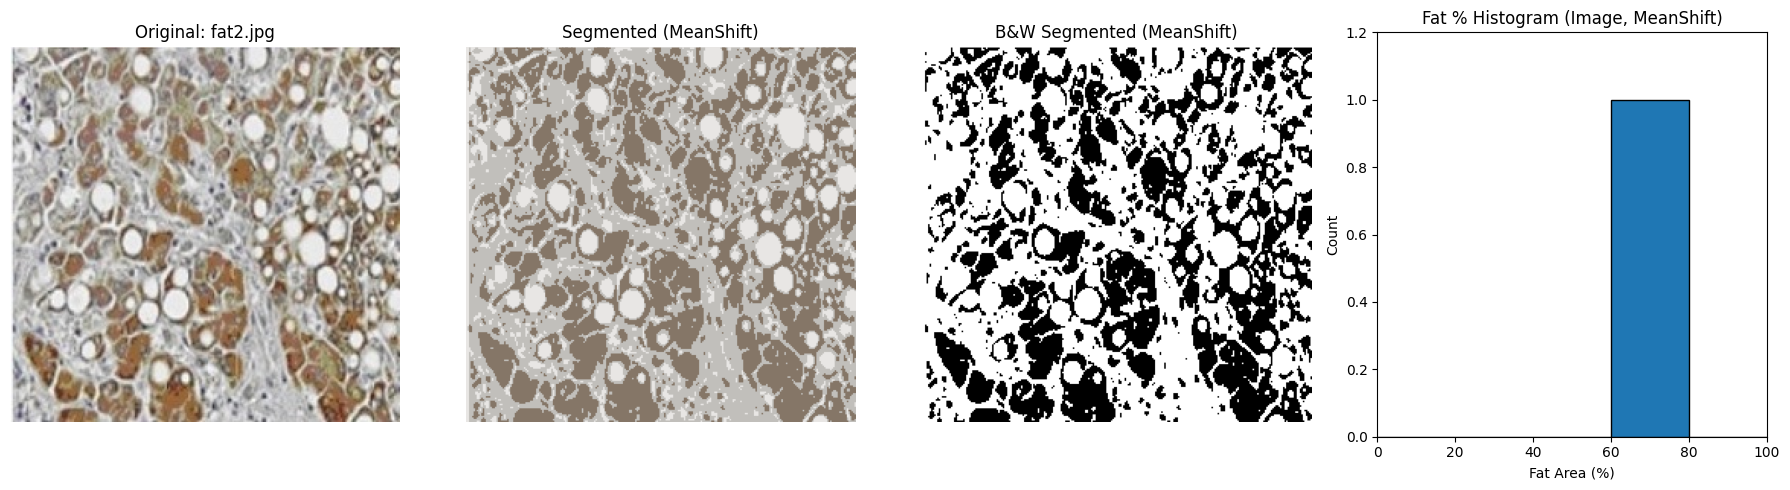


Processing (MeanShift): fat.jpg
Estimated bandwidth: 13.2515
Fat Area (MeanShift): 46.58%


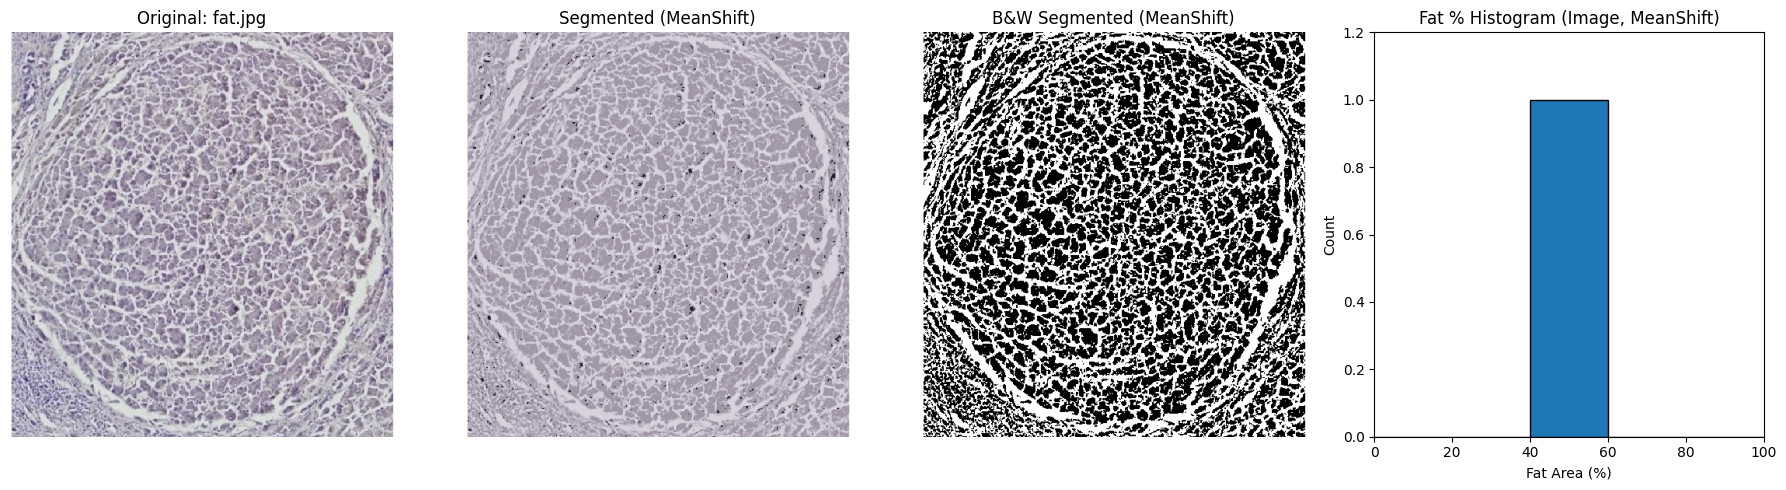


Processing (MeanShift): fat4.png
Estimated bandwidth: 31.2432
Fat Area (MeanShift): 49.24%


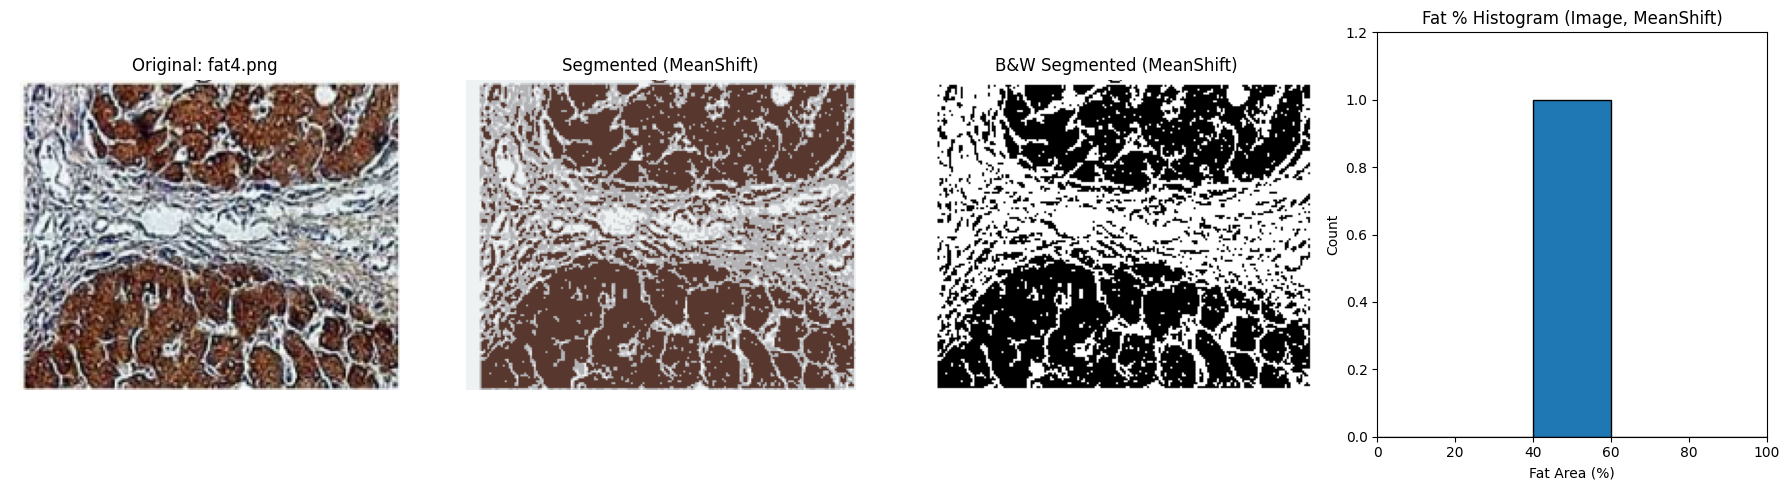


Processing (MeanShift): fat5.png
Estimated bandwidth: 22.8841
Fat Area (MeanShift): 22.93%


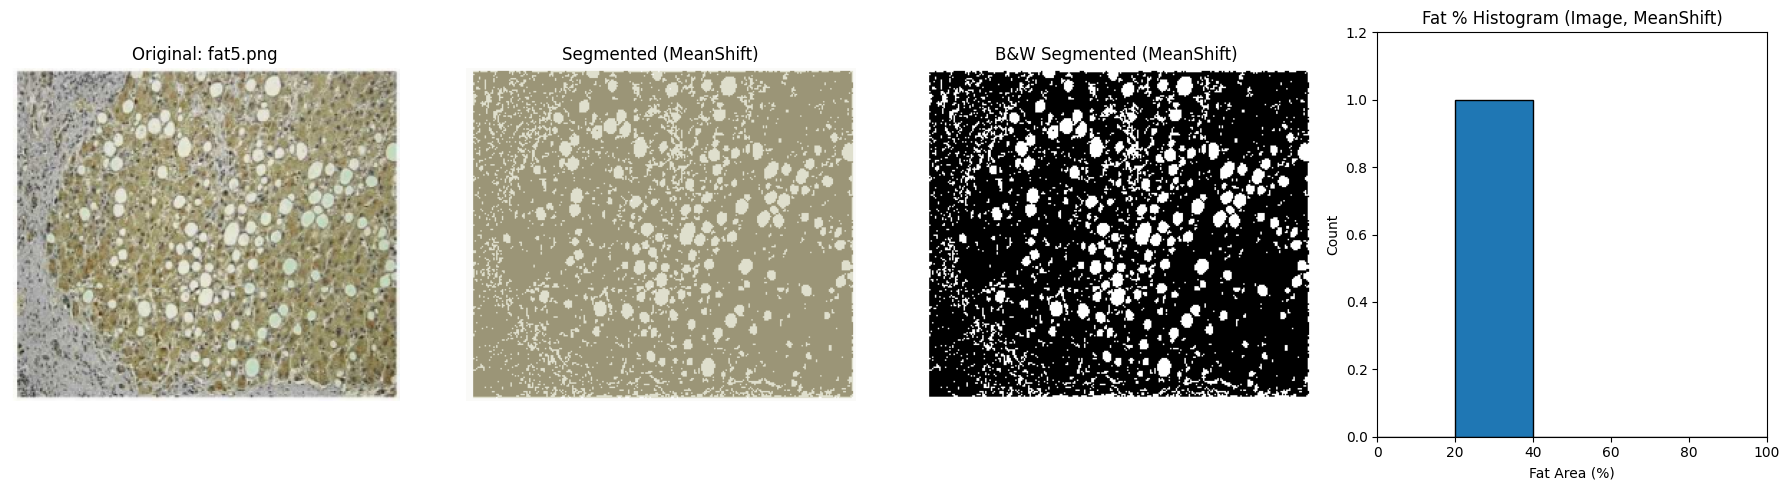


Processing (MeanShift): fat3.png
Estimated bandwidth: 24.7590
Fat Area (MeanShift): 32.07%


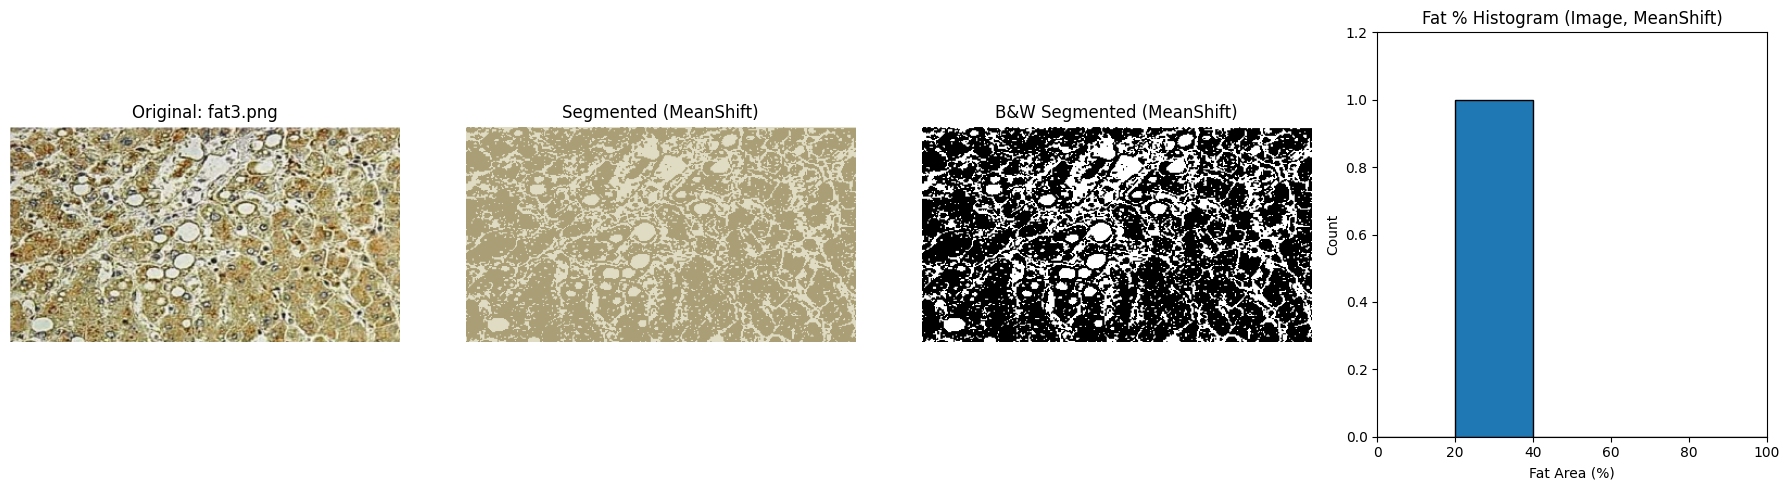

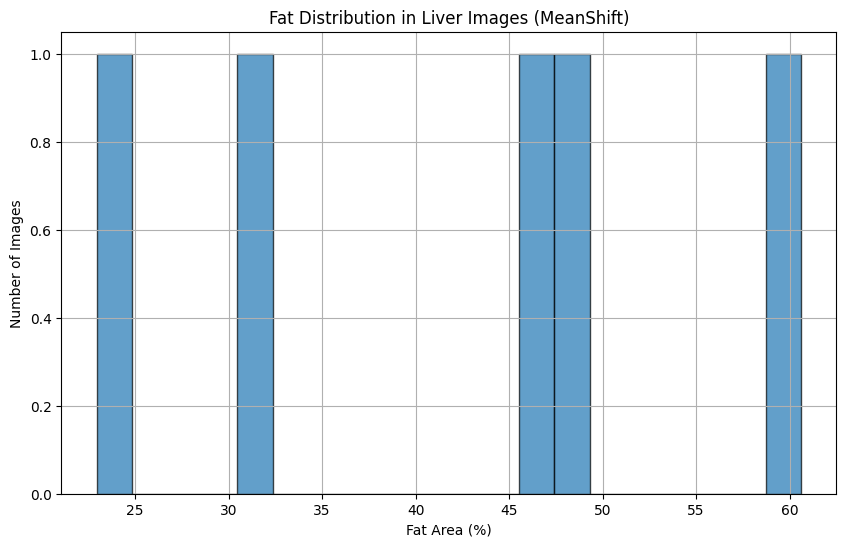


Fat Area Summary Table (MeanShift):
Filename  Fat Area (%)
fat2.jpg     60.610134
 fat.jpg     46.584737
fat4.png     49.244403
fat5.png     22.931985
fat3.png     32.069820


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
from sklearn.cluster import MeanShift, estimate_bandwidth


def meanshift_segment(image_array, quantile=0.1, n_samples=500, bandwidth=None):
    """
    Performs Mean-Shift clustering on the image.

    Args:
        image_array (ndarray): HxWxC image data.
        quantile (float): Parameter for bandwidth estimation.
        n_samples (int): Number of samples for bandwidth estimation.
        bandwidth (float): If provided, uses this bandwidth instead of estimating.

    Returns:
        centroids (ndarray): Cluster centers (as uint8 colors).
        labels (ndarray): Cluster label for each pixel.
        bandwidth (float): Used bandwidth value.
    """
    height, width, channels = image_array.shape
    flat_image = image_array.reshape(-1, channels).astype(np.float64)

    # Estimate bandwidth if not provided
    if bandwidth is None:
        bandwidth = estimate_bandwidth(flat_image, quantile=quantile, n_samples=n_samples)
        print(f"Estimated bandwidth: {bandwidth:.4f}")

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_image)
    centroids = ms.cluster_centers_.astype(np.uint8)
    labels = ms.labels_

    return centroids, labels, bandwidth


def apply_segmentation(image_array, centroids):
    flat = image_array.reshape(-1, image_array.shape[2]).astype(np.float64)
    distances = np.linalg.norm(flat[:, None, :] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    segmented = centroids[labels].reshape(image_array.shape)
    return segmented.astype(np.uint8)


def to_black_and_white(image):
    gray = np.mean(image, axis=2)
    threshold = gray.mean()
    bw = (gray > threshold).astype(np.uint8) * 255
    return bw


def process_image_folder_meanshift(folder_path, quantile=0.1, n_samples=500, bandwidth=None):
    fat_areas = []
    filenames = []

    for filename in os.listdir(folder_path):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        try:
            image_path = os.path.join(folder_path, filename)
            image = np.array(Image.open(image_path).convert('RGB'))

            print(f"\nProcessing (MeanShift): {filename}")
            centroids, labels, used_bw = meanshift_segment(image, quantile, n_samples, bandwidth)
            segmented = apply_segmentation(image, centroids)
            bw_segmented = to_black_and_white(segmented)

            fat_pixels = np.sum(bw_segmented == 255)
            total_pixels = bw_segmented.size
            fat_pct = (fat_pixels / total_pixels) * 100

            fat_areas.append(fat_pct)
            filenames.append(filename)

            print(f"Fat Area (MeanShift): {fat_pct:.2f}%")

            plt.figure(figsize=(18, 5))
            plt.subplot(1, 4, 1)
            plt.imshow(image)
            plt.title(f'Original: {filename}')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(segmented)
            plt.title('Segmented (MeanShift)')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(bw_segmented, cmap='gray')
            plt.title('B&W Segmented (MeanShift)')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.hist([fat_pct], bins=5, range=(0, 100), edgecolor='black')
            plt.title('Fat % Histogram (Image, MeanShift)')
            plt.xlabel('Fat Area (%)')
            plt.ylabel('Count')
            plt.xlim(0, 100)
            plt.ylim(0, 1.2)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

    plt.figure(figsize=(10, 6))
    plt.hist(fat_areas, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Fat Area (%)')
    plt.ylabel('Number of Images')
    plt.title('Fat Distribution in Liver Images (MeanShift)')
    plt.grid(True)
    plt.show()

    df = pd.DataFrame({'Filename': filenames, 'Fat Area (%)': fat_areas})
    print("\nFat Area Summary Table (MeanShift):")
    print(df.to_string(index=False))

    return fat_areas

# === USAGE ===
folder_path = r'/content/drive/MyDrive/fatty lever'
fat_areas_meanshift = process_image_folder_meanshift(folder_path)
